In [189]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Introduction

In this notebook we will investigate Logistic Regression on the Pima Indians Diabetes dataset (https://www.kaggle.com/uciml/pima-indians-diabetes-database) where we will try to predict the onset of Diabetes, based on certain diagnostics and measurements.

Begin by downloading, and importing the data set.

This will be followed by a short recap of logistic regression, and the training procedure. The first set of exercises will ask you to submit a short proof that the sigmoid function always lies between 0 and 1, and also to fit the data-set to a Logistic Regression model.

We then look at choosing the best model for classification. For this, we will consider the same variable selection as seen in the first notebook. We will then have a short introduction on regularization. This is a very important concept in Machine Learning, it can be used to avoid over-fitting, as well as for variable selection (which we will not cover). The second set of exercises consists in choosing the best regularization constant, and exploring its effect on the model.

Finally, we will look at *interpreting* the output of the model to make decisions. We do this by changing the probability thresholds for classification, and explain how we will choose them by considering risk of misclassification.

# Downloading and pre-processing the data

In [67]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [69]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We must then split the data into inputs and outputs. We also remove the Insulin variable, since the data is incomplete (there are ways of dealing with incomplete data, but that is not the purpose of this notebook).

In [71]:
outputs = ['Outcome']
inputs = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X = data[inputs]
Y = data[outputs].to_numpy().reshape(-1)

We will now scale the data. Can you explain why this step needs to be done?

**scaling the data would help us minimize the impact of outliers in our dataset. Already, drwaing insight from "data.describe()"
we could see that some data points are far from the mean**

In [73]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Finally, we divide it into a 80 / 20 training and testing split.

In [75]:
num_of_points = len(Y)

idx = list(range(num_of_points))
np.random.shuffle(idx)
idx_train = idx[:int(num_of_points * 0.8)]
idx_train.sort()
idx_test = idx[int(num_of_points * 0.8):]
idx_test.sort()

X_train = X[idx_train, :]
X_test = X[idx_test, :]

Y_train = Y[idx_train]
Y_test = Y[idx_test]

In [111]:
Y_test

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
      dtype=int64)

# Logistic Regression

Recall that logistic regression is a model that is very well suited to problems where we have a binary output. That is, we are trying to use certain predictors to classify a particular input into one of two classes. We can write this down more formally.

Assume we have a set of predictors $x \in \mathcal{X}$, and a set of outputs $y \in \{0, 1 \}$. We are then interested in estimating the probability of belonging to a certain class, that is, we want to build an estimator, $\hat{p}(x)$, such that:
$$
\hat{p}(x) = \mathbb{P}( Y = 1 | X = x )
$$

There are many real-world scenarios where this might be the case. Consider for example, we might be interested in predicting if a particular individual infected with COVID will need hospital treatment. In this case, we would define $Y = 1$ the scenario where the individual requires treatment, and $Y = 0$ otherwise. For predictors we could use $X = $ age. 

We could decide to use linear regression, that is, a model of the form:
$$
\hat{p}(x) = \beta_0 + x \beta_1
$$

However, we run into trouble. Probabilities must lie between 0 and 1! The linear model is unable to incorporate this property into its predictions!

We can instead wrap our linear model in a function that guarantees all our outputs lie between 0 and 1. We will be using the sigmoid function, defined as:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

After wrapping the linear model, we obtain the logistic regression model, given by:
$$
\hat{p}(x) = \sigma(\beta_0 + x \beta_1)
$$

Which we can write as:
$$
\hat{p}(x) = \frac{e^{\beta_0 + x \beta_1}}{1 + e^{\beta_0 + x \beta_1}}
$$

# Training the function

The parameters of a linear regression model can be estimated using least squares. However, it is not the best optimiser for logistic regression. This is because we are not estimating $Y$ directly, instead we are estimating $\textit{the probability}$ of Y. This means maximum likelihood estimation is much more appropriate for logistic regression. We can write the likelihood function easily:
$$
\mathcal{L} = \prod_{i : y_i = 1} \mathbb{P}(Y = 1 | X = x_i) \prod_{i' : y_{i'} = 0} (1 - \mathbb{P}(Y = 0 | X = x_{i'}))
$$

Instead of maximising this directly, it is more common to minimise the negative log-likelihood:
$$
\ell(\beta) = - \log \mathcal{L}(\beta) = - \sum_{i : y_i = 1} \log\sigma(x_i^T \beta) - \sum_{i' : y_{i'} = 0}\log \sigma(x_{i'}^T\beta)
$$
So that we choose our parameters, $\hat{\beta}$:
$$
\hat{\beta} = \arg\min_{\beta} \ell(\beta)
$$

Finding the minimum can easily be done using any gradient-based optimiser. In addition, we can also add regularization, which helps us avoid overfitting. We will begin by investigating this.

## Exercise 1:

1. Prove that the sigmoid function always gives an output between 0 and 1. (Hint: consider the limits as $x \rightarrow \pm \infty$, and show the function is always increasing).


To prove that the sigmoid function output between 0 and 1; first, as x approaches positive(+) or negative(-) infinity

2. Using scikit.learn's LogisticRegression class, train a model on the data-set above, make sure you are not regularizing (read the sklearn's documentation! - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Show the model's training and test accuracy, and build a confusion matrix for each set. (Hint: the functions required are $ \texttt{.fit()} $, $\texttt{.predict()}$, and $\texttt{confusion\_matrix()}$.

## Excercise 2

Regularization happens when we add a penalty to the loss function. We do this to decrease the complexity of the model, in an attempt to stop the model from over-fitting. Ideally, this should lead to better generalization. To be more precise, for L2 regularization we will now choose our parameters by minimizing the modified loss function:
$$
\hat{\beta} = \arg\min_\beta \{ C \cdot \ell(\beta) + \frac{1}{2}\beta^T \beta \}
$$

Note that the new penalization means that $\beta$ should be closer to zero (this is what we mean by 'a simpler model').

Investigate the effect of L2 regularization. In particular, focus on the how the testing accuracy changes for different values of $C$. Create a plot that shows how $C$ varies, starting at $10^{-6}$ and ending at $10^{-2}$.

1. What behaviour do you observe as you increase regularization (that is, as $C$ becomes small)?

2. From your investigation, choose the best regularization constant. How does it compare with previous testing accuracy?

3. For which values of $C$ can you recover your previous training accuracy? Can you explain why does this happen?

# Probability Thresholds

Recall that we are not estimating $Y$ directly, but instead the probability of $Y = 1 | X$. So far, our classification has been based on the which class has the higher probability. In other words, we have been using the classifier:
$$
  \hat{Y}(x) =
    \begin{cases}
      0 & \text{if } \hat{p}(x) < 0.5 \\
      1 & \text{if } \hat{p}(x) \geq 0.5 \\
    \end{cases}       
$$

However, we must also consider that the probability threshold of 0.5 might not be optimal. Indeed, consider our current data-set. Let's say we were going to use our model to decide who should go see a doctor and possibly get preventive treatment. In this case, incorrectly predicting that someone will not have Diabetes, when they will, is very costly - the person might face severe health consequences. On the other hand, incorrectly saying someone will have Diabetes, when they won't, is not as bad because the doctor would be able to catch this, and we would just waste a little time. 

This is one of the greatest strengths of logistic regression. The way we define and train them, mean we obtain good uncertainty estimates, so that we might make risk assessments!

## Exercise 3

1. Train a new logistic regression model, using the best regularization constant you found in exercise 2.

2. Build a new function which takes as inputs: your Logistic Regression model, a set of $X$ values in which to predict, and a probability threshold $T_p$. The function should return an array of predictions based on the new probability threshold. (Hint:  use the $\texttt{predict\_proba}$ method in $\texttt{LogisticRegression}$)

3. Investigate the effect of the probability threshold on the number of False Negatives and False Positives. Based on this analysis, what probability threshold would YOU choose? What kind of information would you want to make such a decision?

## EXERCISE 1a
Proving that the sigmoid function always gives an output between 0 and 1, :

- The sigmoid function takes any real number as input and transforms it into a value between 0 and 1. It does this by applying an exponential transformation that ensures the output is always bounded.  

- When x becomes very large (approaching positive infinity), the function's denominator grows significantly, making the output approach 1.  

- When x becomes very small (approaching negative infinity), the exponential term in the denominator becomes very large, making the output approach 0.
This shows that the function is naturally constrained within (0,1). Showing the function is always increasing  

- The sigmoid function is always increasing because its slope is always positive. This means that as you increase the input value, the output also increases but never exceeds 1.  
Similarly, as you decrease the input value, the output decreases but never falls below 0.  
**In Conclusion, because the sigmoid function is bounded (never exceeding 1 or falling below 0) and always increasing, we can confidently say that it always produces an output between 0 and 1, regardless of the input value.**

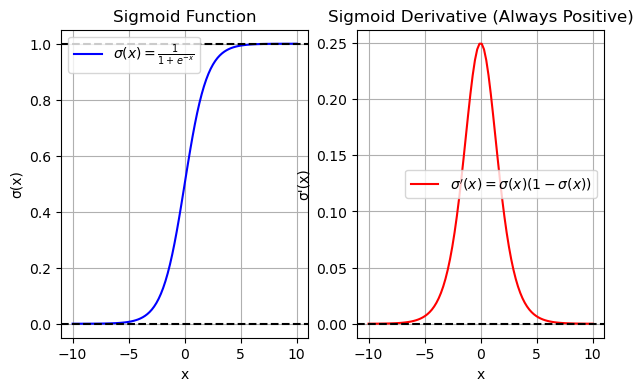

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the derivative of the sigmoid function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Generate x values
x = np.linspace(-10, 10, 100)

# Compute sigmoid and its derivative
y = sigmoid(x)
dy = sigmoid_derivative(x)

# Plot the sigmoid function
plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y, label=r'$\sigma(x) = \frac{1}{1 + e^{-x}}$', color='blue')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=1, color='black', linestyle='--')
plt.title("Sigmoid Function")
plt.xlabel("x")
plt.ylabel("σ(x)")
plt.legend()
plt.grid()

# Plot the derivative of the sigmoid function
plt.subplot(1, 2, 2)
plt.plot(x, dy, label=r"$\sigma'(x) = \sigma(x)(1 - \sigma(x))$", color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Sigmoid Derivative (Always Positive)")
plt.xlabel("x")
plt.ylabel("σ'(x)")
plt.legend()
plt.grid()

plt.show()


### EXERCISE 1b

In [80]:
model = LogisticRegression(penalty=None, solver='lbfgs')  
model.fit(X_train, Y_train)

LogisticRegression(penalty=None)

In [121]:
pred = model.predict(X_train)

In [117]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check accuracy
accuracy = accuracy_score(Y_train, pred)
print("Training Accuracy:", accuracy)


Training Accuracy: 0.7785016286644951


Training Accuracy: 0.7785
Test Accuracy: 0.7532


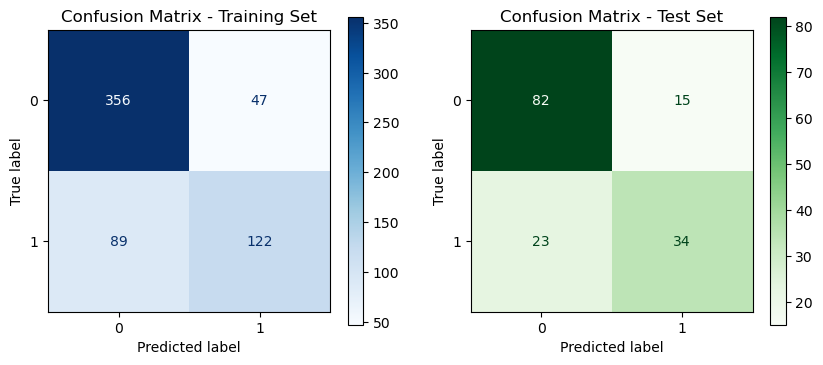

In [141]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Compute accuracy
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute confusion matrices
cm_train = confusion_matrix(Y_train, Y_train_pred)
cm_test = confusion_matrix(Y_test, Y_test_pred)

# Display confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Training Set Confusion Matrix
disp_train = ConfusionMatrixDisplay(cm_train, display_labels=[0, 1])
disp_train.plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix - Training Set")

# Test Set Confusion Matrix
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=[0, 1])
disp_test.plot(ax=axes[1], cmap="Greens")
axes[1].set_title("Confusion Matrix - Test Set")

plt.show()

# Exercise 2a

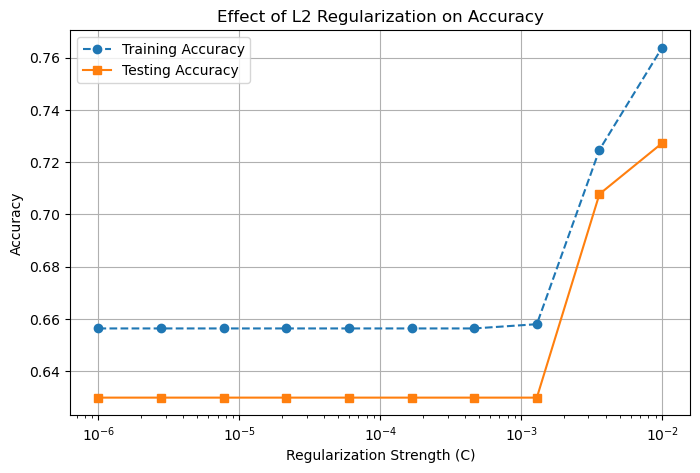

In [153]:

# Define the range of C values (inverse of regularization strength)
C_values = np.logspace(-6, -2, 10)  # Log-spaced values from 10⁻⁶ to 10⁻²

train_accuracies = []
test_accuracies = []

for C in C_values:
    # Train logistic regression with L2 regularization
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000)
    model.fit(X_train, Y_train)
    
    # Compute accuracies
    train_acc = accuracy_score(Y_train, model.predict(X_train))
    test_acc = accuracy_score(Y_test, model.predict(X_test))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(C_values, train_accuracies, marker='o', label="Training Accuracy", linestyle='dashed')
plt.plot(C_values, test_accuracies, marker='s', label="Testing Accuracy", linestyle='solid')

plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Accuracy")
plt.title("Effect of L2 Regularization on Accuracy")
plt.legend()
plt.grid(True)
plt.show()


1. What behaviour do you observe as you increase regularization (that is, as $C$ becomes small)?  
**As C becomes small, Low 𝐶(stronger regularization), Test accuracy drops because the model is too simple and underfits the data.**
2. From your investigation, choose the best regularization constant. How does it compare with previous testing accuracy?  
    - **The best C value is around 10^−2, where test accuracy is highest. This is the point where the model achieves good generalization without overfitting.**  
    - **For small C values (10^−6 to 10^−3), testing accuracy remains low (0.63 - 0.64).  
   However, at C value=10^-2, testing accuracy improves significantly to 0.73;
 This shows that a moderate amount of regularization allows the model to generalize well, improving test performance.**

3. For which values of $C$ can you recover your previous training accuracy? Can you explain why does this happen?  
**For small 𝐶 (up to 10^−3 ), training accuracy remains near the original value of 0.66. For large C at 10^−2, training accuracy increases significantly upto 0.76, indicating overfitting. This happens because stronger regularization (small C) forces model simplicity, while weaker regularization (large C) allows complexity and better fit to training data.**


## EXERCISE 3

Training Accuracy: 0.7687
Testing Accuracy: 0.7662


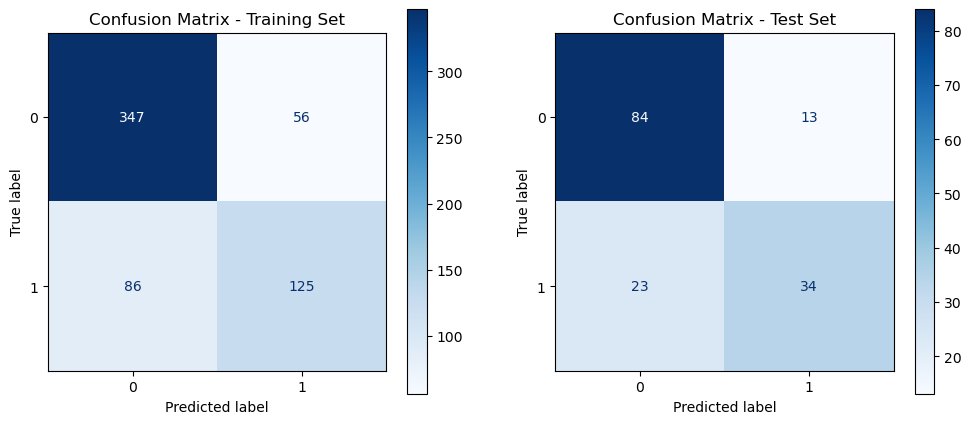

In [191]:

# Train the logistic regression model with the best C value
best_C = 10**-2
model = LogisticRegression(C=best_C, penalty='l2', solver='liblinear')
model.fit(X_train, Y_train)

# Predict on training and test sets
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Compute accuracy
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrices
cm_train = confusion_matrix(Y_train, Y_train_pred)
cm_test = confusion_matrix(Y_test, Y_test_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
disp_train = ConfusionMatrixDisplay(cm_train, display_labels=[0, 1])
disp_train.plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix - Training Set")

# Testing Confusion Matrix
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=[0, 1])
disp_test.plot(ax=axes[1], cmap="Blues")
axes[1].set_title("Confusion Matrix - Test Set")

plt.show()


1. Train a new logistic regression model, using the best regularization constant you found in exercise 2.

In [193]:
# Define the best C value from previous results
best_C = 1e-2  # Example: Adjust based on your findings

# Train the logistic regression model with L2 regularization
model = LogisticRegression(C=best_C, penalty='l2', solver='lbfgs')
model.fit(X_train, Y_train)

# Evaluate performance
train_accuracy = model.score(X_train, Y_train)
test_accuracy = model.score(X_test, Y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.7638
Testing Accuracy: 0.7273


2. Build a new function which takes as inputs: your Logistic Regression model, a set of $X$ values in which to predict, and a probability threshold $T_p$. The function should return an array of predictions based on the new probability threshold. (Hint:  use the $\texttt{predict\_proba}$ method in $\texttt{LogisticRegression}$)


In [195]:
def custom_predict(model, X, T_p=0.5):
    """
    Predicts class labels based on a given probability threshold.
    
    Parameters:
        model: Trained Logistic Regression model
        X: Feature set for prediction
        T_p: Probability threshold (default=0.5)
    
    Returns:
        Array of predictions (0 or 1)
    """
    probabilities = model.predict_proba(X)[:, 1]  # Get probabilities for class 1
    return (probabilities >= T_p).astype(int)  # Convert probabilities to class labels


In [215]:
preds = custom_predict(model, X_test, T_p=0.7)  # Adjust threshold as needed
preds

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [213]:
preds = custom_predict(model, X_test, T_p=0.3)  # Adjust threshold as neede
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0])

3. Investigate the effect of the probability threshold on the number of False Negatives and False Positives. Based on this analysis, what probability threshold would YOU choose? What kind of information would you want to make such a decision?

In [233]:
def evaluate_threshold(model, X, Y, thresholds=[0.3, 0.5, 0.7]):
    """
    Evaluates how FP and FN change with different probability thresholds.
    
    Parameters:
        model: Trained Logistic Regression model
        X: Feature set for prediction
        Y: True labels
        thresholds: List of thresholds to evaluate
    
    Returns:
        None (Prints confusion matrices)
    """
    for T_p in thresholds:
        preds = custom_predict(model, X, T_p)
        tn, fp, fn, tp = confusion_matrix(Y, preds).ravel()
        
        print(f"\nThreshold: {T_p}")
        print(f"False Positives: {fp}, False Negatives: {fn}")
        print(f"Confusion Matrix:\n{confusion_matrix(Y, preds)}")

# Run analysis
evaluate_threshold(model, X_test, Y_test, thresholds=[0.3, 0.5, 0.7])

print('\nBased on this condition of "incorrectly predicting that someone will not have Diabetes, when they will, is very costly"')
print('Hemce, The best probability threshold for this scenario is 0.3')
print('because it significantly reduces False Negatives (FN = 9), ensuring that fewer diabetic patients go undiagnosed.')



Threshold: 0.3
False Positives: 34, False Negatives: 9
Confusion Matrix:
[[63 34]
 [ 9 48]]

Threshold: 0.5
False Positives: 10, False Negatives: 32
Confusion Matrix:
[[87 10]
 [32 25]]

Threshold: 0.7
False Positives: 1, False Negatives: 54
Confusion Matrix:
[[96  1]
 [54  3]]

Based on this condition of "incorrectly predicting that someone will not have Diabetes, when they will, is very costly"
Hemce, The best probability threshold for this scenario is 0.3
because it significantly reduces False Negatives (FN = 9), ensuring that fewer diabetic patients go undiagnosed.
